# Machine Learning with Text

We now turn our attention to a special case of machine learning, namely how to do ML when your data is a collection of text. This falls under the perview of _natural language processing_ (NLP). [NLP](https://en.wikipedia.org/wiki/Natural_language_processing) is a vast subfield of computer science that deals with how to program computers to process and analyze large amounts of "natural" language data. This includes both speech and text, though we'll only focus on text here. Specifically, we'll learn just enough NLP to do ML on text datasets, and no more than that for now.

Since this is a security group we'll build a spam classifier from scratch. The dataset we'll use is the [SMS spam dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset), which we download off Kaggle using the shell command below. Kaggle is a great resource for datasets, and comes with its own specific version of `wget`, called `kaggle`, to handle downloading and managing its own datasets. The SMS dataset contains several thousand SMS messages collected in the UK several years ago, some of which are labeled as spam and some of which are labeled as non-spam.

Note: We've already pre-downloaded this dataset into the `resources` directory. If you'd rather use Kaggle directly and don't already have `kaggle` installed you can install by following the instructions [here](https://github.com/Kaggle/kaggle-api). Then uncomment out the first cell and run it. You can use terminal commands in Jupyter Notebook by prefixing the commands with `!`, which is what we do below to get the data.

The goal of this notebook is to build a classifier to classify spam vs nonspam in this dataset of SMS messages. We start as always by loading the packages we'll need. Since NLP is a rich field with lots of intricacies, there are several Python packages designed for doing NLP. Among the most popular right now are NLTK, Spacy, and Gensim. 

We'll be working with NLTK and Spacy here to help with text processing. Since the dataset is unbalanced we'll also make use of the Imbalanced-Learn library, and of course Scikit-Learn to do the ML. We also use a special package for generating word clouds. After this we define several functions that will be used to load in the text, process the text, and visualize the text. We'll address what these do in a lot more below.

**Important Update (April 2020)**: I made one major change to this notebook from the previous versions that both illustrates some new points and results in substantial model performance improvement. Namely, I added a function under the text normalization to convert many common patterns to special tokens (prefixed by `xx`). These special tokens simultaneously denoise the text a lot while preserving a lot of the information in the text that got stripped out or were left un-normalized before (including capitalization, phone numbers, monitary values, URLs, and text emojis). To see how important these special tokens are, look at how the feature importance plot at the bottom has changed since. The model performances jumped from F1 scores of (92.3%, 93.2%) to (96.3%, 96.7%) respectively. Apologies if I haven't yet updated all of the text below to reflect this. Will soon.

In [1]:
#! kaggle datasets download -d uciml/sms-spam-collection-dataset -p ~/.kaggle
#! unzip ~/.kaggle/sms-spam-collection-dataset.zip
#! mv spam.csv ../resources

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

from pathlib import Path
from wordcloud import WordCloud
import re
import string
import spacy
from collections import Counter

import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

np.random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rkingery/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We start of course by loading in the text. A dataset of text are usually called a _corpus_ in NLP, and each separate string of text is called a _document_. We use the ever-useful Pandas library to load the spam dataset into a dataframe. The first column are the labels, with "1" being "spam" and "0" being "nonspam". The second column contains the corresponding documents. For example, the document in row 1 is classified as "0", i.e. nonspam. Etc.

In [3]:
def get_text(text_file):
    df = pd.read_csv(text_file, encoding='ISO-8859-1')
    df = df[['v1','v2']]
    df.columns = ['labels','text']
    df.labels = df.labels.replace('ham',0)
    df.labels = df.labels.replace('spam',1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

text_file = Path().cwd().parent / 'resources' / 'spam.csv'
df = get_text(text_file)
df.head(10)

,labels,text
0,0,"Funny fact Nobody teaches volcanoes 2 erupt, t..."
1,0,I sent my scores to sophas and i had to do sec...
2,1,We know someone who you know that fancies you....
3,0,Only if you promise your getting out as SOON a...
4,1,Congratulations ur awarded either å£500 of CD ...
5,0,"I'll text carlos and let you know, hang on"
6,0,K.i did't see you.:)k:)where are you now?
7,0,No message..no responce..what happend?
8,0,Get down in gandhipuram and walk to cross cut ...
9,0,You flippin your shit yet?


One of the first things you should always do when working with a labeled dataset is to see how unbalanced your dataset is. Below, we can see that only 747 of the 5572 are spam, which means the dataset is a bit unbalanced. This means we'll have to use metrics other than accuracy for classification, and possibly use upsampling or downsampling to balance the training sets.

In [4]:
print('number of spams: ',len(df[df.labels==1]))
print('number of non-spams: ',len(df[df.labels==0]))
print('number of documents: ', len(df))

number of spams:  747
number of non-spams:  4825
number of documents:  5572


Below we print a few of the SMS messages along with their corresponding labels. Notice how messy the text is, with people often misspelling words and using abbreviations and poor puncuation. Also notice that non-ascii symbols are showing up in the dataset. All of these we'll want to fix as much as possible before doing any ML because they add noise to the data. It'll be practically impossible to address them all, but we can try to fix as much as we can. The need to pre-process text is a common headache when doing ML with text data.

In [5]:
def show_examples(df):
    sms = df[df.labels==0].iloc[0]
    print('label:',sms.labels)
    print(sms.text)

    print()

    sms = df[df.labels==0].iloc[1]
    print('label:',sms.labels)
    print(sms.text)

    print()

    sms = df[df.labels==1].iloc[0]
    print('label:',sms.labels)
    print(sms.text)

    print()

    sms = df[df.labels==1].iloc[1]
    print('label:',sms.labels)
    print(sms.text)

show_examples(df)

label: 0
Funny fact Nobody teaches volcanoes 2 erupt, tsunamis 2 arise, hurricanes 2 sway aroundn no 1 teaches hw 2 choose a wife Natural disasters just happens

label: 0
I sent my scores to sophas and i had to do secondary application for a few schools. I think if you are thinking of applying, do a research on cost also. Contact joke ogunrinde, her school is one me the less expensive ones

label: 1
We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150p

label: 1
Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16


Before processing the text, I want to at least show you how to do word clouds since a lot of people seem to like them for data viz purposes (in my opinion more than is justified). Word clouds are basically just pictures that show the most common words in a dataset. The more a word appears in the dataset the bigger it appears in the word cloud.

Below we plot two word clouds, one for the spam text only, and another for the nonspam text only. Can you see any common themes between the two, and any obvious differences?

spam wordcloud


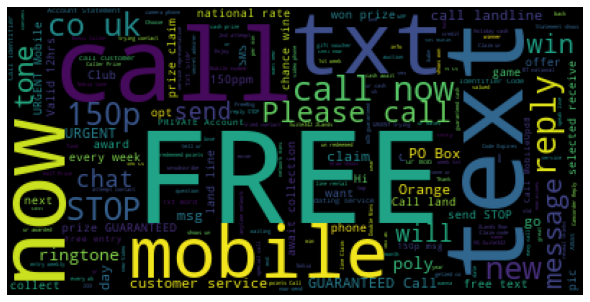

nonspam wordcloud


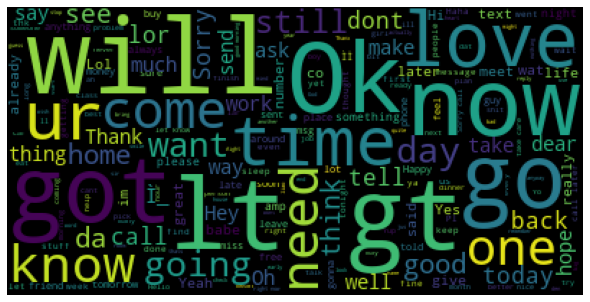

In [6]:
def show_wordcloud(text):
    text = ' '.join([t for t in text])
    wordcloud = WordCloud().generate(text)
    plt.figure(figsize=(8,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

print('spam wordcloud')
spams = df.text[df.labels==1]
show_wordcloud(spams)

print('nonspam wordcloud')
nonspams = df.text[df.labels==0]
show_wordcloud(nonspams)

## Text Normalization and Tokenization

We now get to the nitty gritty part of NLP, taking raw text, processing (aka normalizing) it, and turning into vectors of numbers to do ML with. Classical NLP tends to follow the [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) model. Bag of words basically means that we only care which words appear in the text and how often they appear, not the order in which they appear. This means the order of text in a document won't matter, only the frequency of words that appear.

When doing bag of words, these are some of the most common normalization steps people take. Note in practice you'd want to experiment with subsets of these and other normalization schemes. We choose here to do all of these to illustrate what they do.

- Identify important words / symbols / phrases that you think mean the same thing, and combine them into a single token. For example, if you determine the presence of phrases referencing money is important to your problem (as it might be for spam classification), then you might convert all monitary symbols to a dollar sign `$`. This way, the importance of the fact that money appears gets emphasized by a single feature `$`.
- All text is converted to lower case, that way strings like "love" and "Love" and "LOVE" are treated as one word "love". 
- Punctuation and unusual characters (for English this often might mean non-ascii characters) are removed.
- Stop words, i.e. common English words that occur frequently in text, are removed. These include words like I, we, you, your, to, and, but, etc. The idea is that these words capture very little of the meaning of a sentence, and since they occur so frequently it's often better to remove them so they don't overly skew the results of the model.
- Text is lemmatized or stemmed, which means that words occurring in different inflections are changed to their root word. For example, words like "walk", "walking", and "walked" are changed to the root word "walk". And words like "cat", "catty", and "catlike" are changed to their root word "cat". The idea here is that the root word itself carries more meaning than whatever inflection it happens to appear in in a sentence.

Note: When using more state of the art techniques like deep learning, you may not actually want to take some of the above steps, as you lose some information. For example, there is often subtle information encapsulated in capitalization that you might be throwing away. There's may be a different semantic meaning in saying something like "I love this" vs "I LOVE this!!!!". This is particularly true when working with stuff like tweets or other social media where lots of informal language and emojis are used. Let your problem dictate what normalization you do and don't do.

We use the `normalize_text` function defined above to perform these steps on our raw text, and store this processed text in a new `text_processed` in the dataframe. Observe that words like `Funny` get turned into stuff like `funni`. This is done in purpose by many stemmers, even if it looks weird, and it's not something to worry about.

Note: when normalizing text, having a good knowledge of regular expressions and the pythong `re` library is essential since you'll use them like crazy to clean up text.

In [7]:
def sub_special_tokens(text):
    # note I stole many of these regexes regularly from S.O.
    # convert simple URLs to xxurl token (e.g. www.google.com, http:google.com -> xxurl)
    text = re.sub(r' www.', ' http://www.', text)
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', ' xxurl ', text)
    # convert (British) phone numbers to xxphone token (e.g. 09058097218 -> xxphone)
    pat = r'\d{3}[-\.\s]??\d{4}[-\.\s]??\d{4}|\d{5}[-\.\s]??\d{3}[-\.\s]??\d{3}|(?:\d{4}\)?[\s-]?\d{3}[\s-]?\d{4})'
    text = re.sub(pat, ' xxphone ', text)
    # replace monetary values with xxmon token
    text = text.replace('£','$ ')
    text = re.sub(r'\$[ ]*(\d+[,\.])*\d+', ' xxmon ', text)
    # convert all other numbers to xxnum token (e.g. 123, 1.2.3, 1-2-3 -> xxnum)
    text = re.sub(r'\b([.-]*[0-9]+[.-]*)+\b', ' xxnum ', text)
    # put xxup token before words in all caps (easy way to recognize info from capitalizing a word)
    text = re.sub(r'(\b[A-Z][A-Z0-9]*\b)', r' xxup \1 ', text)
    # put xxcap token before words with capitalized first letter (easy way to recognize first word in a sentence)
    text = re.sub(r'(\b[A-Z][a-z0-9]+\b)', r' xxcap \1 ', text)
    # convert some common text "emojis" to xxemoji: ;), :), :(, :-(, etc
    text = re.sub(r'[:;][ ]*[-]*[ ]*[()]', ' xxemoji ', text)
    return text

def normalize_text(text):
    # converts common patterns into special tokens
    text = sub_special_tokens(text)
    # convert text to lowercase
    text = text.lower()
    # strip out any lingering html tags
    text = re.sub(r'<[^>]*>', '', text)
    # convert all "&" symbols to "and" so they're the same token
    text = text.replace('&',' and ')
    # put spaces between punctuation (eg: 9.Blah -> 9 . Blah)
    puncts = r'[' + re.escape(string.punctuation) + r']'
    text = re.sub('(?<! )(?=' + puncts + ')|(?<=' + puncts + ')(?! )', r' ', text)
    # strip non-ascii characters (easy way to denoise text a bit)
    text = text.encode("ascii", errors="ignore").decode()
    # remove all punctuation except ' and ?
    text = re.sub(r"[^\w\s'?]",'',text)
    # remove nltk's common set of stop words (common for classical NLP analysis)
    stop_words = stopwords.words('english')
    text = ' '.join(word for word in text.split() if word not in stop_words)
    # stem words using nltk snowball stemmer, e.g. converts {run, running, runs} all to "run"
    stemmer = SnowballStemmer('english')
    stemmed_text = ''
    for word in text.split():
            stemmed_text = stemmed_text + stemmer.stem(word) + ' '
    text = stemmed_text
    # sub the occurance of 2 or more spaces with a single space
    text = re.sub(r'[ ]{2,}',' ',text)
    return text

df['text_processed'] = df.text.apply(normalize_text)
df.head(10)

,labels,text,text_processed
0,0,"Funny fact Nobody teaches volcanoes 2 erupt, t...",xxcap funni fact xxcap nobodi teach volcano xx...
1,0,I sent my scores to sophas and i had to do sec...,xxup sent score sopha secondari applic school ...
2,1,We know someone who you know that fancies you....,xxcap know someon know fanci xxcap call xxphon...
3,0,Only if you promise your getting out as SOON a...,xxcap promis get xxup soon xxcap ' text morn l...
4,1,Congratulations ur awarded either å£500 of CD ...,xxcap congratul ur award either xxmon xxup cd ...
5,0,"I'll text carlos and let you know, hang on",xxup ' text carlo let know hang
6,0,K.i did't see you.:)k:)where are you now?,xxup k ' see xxemoji k xxemoji ?
7,0,No message..no responce..what happend?,xxcap messag responc happend ?
8,0,Get down in gandhipuram and walk to cross cut ...,xxcap get gandhipuram walk cross cut road xxca...
9,0,You flippin your shit yet?,xxcap flippin shit yet ?


The next essential step before doing ML is tokenization, which involves converting strings into a list of tokens that will later be converted into numbers for the ML model. There are many different tokenizers out there. NLTK has one of its own. We use the spacy tokenizer here since it often seems to do a better job (it's newer than nltk's tokenizer).

Note: If this is your first time using spacy, you'll need to download the language model `en_core_web_sm` first using `python -m spacy download en_core_web_sm`.

Naively speaking, tokenizing a sentence means splitting it into whatever base unit you want to encode. Most of the time it's usually words (called unigrams) or pairs of words (called bigrams). An example of naive unigram tokenization is shown directly below. You're basically just splitting a string on spaces. 

As you can see from the example this doesn't do a terribly good job. For one thing there's a trailing empty string at the end. For another the contraction "I'll", short for "I will", is treated as a single word. Good tokenizers will recognize situations like this and split them accordingly. For example, spacy converts `i'll` into the two tokens `i` and `'ll`. Similarly, stuff like `can't` become `can` and `'t`. Any empty strings and extra whitespace are also removed. We can see how this works in the second cell below.

In [8]:
sms = df.iloc[5]
doc = sms.text_processed.split(' ')
[token for token in doc]

['xxup', "'", 'text', 'carlo', 'let', 'know', 'hang', '']

In [9]:
nlp = spacy.load('en_core_web_sm')
sms = df.iloc[5]
doc = nlp(sms.text_processed)
[token.text for token in doc]
#grams = [sentence[i:i+N] for i in xrange(len(sentence)-N+1)]

['xxup', "'", 'text', 'carlo', 'let', 'know', 'hang']

We now tokenize the whole corpus of processed text, and store these tokens as strings in the `tokens` column of the dataframe. Notice that even after tokenization there are weird things showing up in the data due to misspellings, e.g. `ki` and `did't`. Trying to correct all of these is an often impossible task. If the same misspelling patterns don't occur too often, it's often easier just to cut them out by keeping only the most frequently occurring tokens, which are hopefully spelled correctly.

In [10]:
def tokenize(text, nlp):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    tokens = ' '.join(token.text for token in doc)
    return tokens

nlp = spacy.load('en_core_web_sm')
df['tokens'] = df.text_processed.apply(lambda x:' '.join(t.text for t in nlp.tokenizer(x)))
df.head(10)

,labels,text,text_processed,tokens
0,0,"Funny fact Nobody teaches volcanoes 2 erupt, t...",xxcap funni fact xxcap nobodi teach volcano xx...,xxcap funni fact xxcap nobodi teach volcano xx...
1,0,I sent my scores to sophas and i had to do sec...,xxup sent score sopha secondari applic school ...,xxup sent score sopha secondari applic school ...
2,1,We know someone who you know that fancies you....,xxcap know someon know fanci xxcap call xxphon...,xxcap know someon know fanci xxcap call xxphon...
3,0,Only if you promise your getting out as SOON a...,xxcap promis get xxup soon xxcap ' text morn l...,xxcap promis get xxup soon xxcap ' text morn l...
4,1,Congratulations ur awarded either å£500 of CD ...,xxcap congratul ur award either xxmon xxup cd ...,xxcap congratul ur award either xxmon xxup cd ...
5,0,"I'll text carlos and let you know, hang on",xxup ' text carlo let know hang,xxup ' text carlo let know hang
6,0,K.i did't see you.:)k:)where are you now?,xxup k ' see xxemoji k xxemoji ?,xxup k ' see xxemoji k xxemoji ?
7,0,No message..no responce..what happend?,xxcap messag responc happend ?,xxcap messag responc happend ?
8,0,Get down in gandhipuram and walk to cross cut ...,xxcap get gandhipuram walk cross cut road xxca...,xxcap get gandhipuram walk cross cut road xxca...
9,0,You flippin your shit yet?,xxcap flippin shit yet ?,xxcap flippin shit yet ?


Before proceeding with the text classification, it's a good idea to get an idea of the word frequency in the dataset. Which words appear most often in our list of tokens? We can use this using Python's `Counter` class, which is used to find the calculate the of times elements in a list occur. We create a counter of all the words in our corpus and print the top 20 most common words. Observe that obvious stopwords like "i" are still appearing, along with several possible misspellings like "u" and "gt" and "lt". Normally we should fix this before moving on. However, sklearn will take care of some of these stopwords for us so we won't bother doing this here.

In [11]:
vocab_list = ' '.join(t for t in df.tokens).split(' ')
counts = Counter(vocab_list)

print(f'number of unique tokens in dataset: {len(counts)}')

number of unique tokens in dataset: 6555


In [12]:
print('top words', '\t', 'count')
print('----------------------')
for word,count in counts.most_common(20):
    print(f'{word}\t\t{count}')

top words 	 count
----------------------
xxcap		11581
xxup		6614
xxnum		2147
'		1871
?		1540
u		1186
call		680
xxphone		456
go		453
get		452
xxemoji		407
ur		385
nt		368
xxmon		341
gt		318
lt		316
come		301
ok		292
free		284
know		274


## Text Classification

Before proceeding with the ML it's a good idea to check if there is significant class imbalance. Recall from above that in this case there is, as 86.6% of the data is labeled as non-spam. This means you should at least consider some kind of resampling strategy for training. For simplicity, we'll use naive oversampling, i.e. the `RandomOverSampler` imblearn class. We also define a convenience function to get and print the model metrics for later.

In [13]:
y = df.labels
y.value_counts(normalize=True)

0    0.865937
1    0.134063
Name: labels, dtype: float64

In [14]:
def get_scores(y,yhat):
    print('accuracy: ', round(accuracy_score(y,yhat),4))
    print('precision: ', round(precision_score(y,yhat),4))
    print('recall: ', round(recall_score(y,yhat),4))
    print('f1: ', round(f1_score(y,yhat),4))
    print('auc: ', round(roc_auc_score(y,yhat),4))
    print('confusion matrix:\n', confusion_matrix(y,yhat))

### Bag of Words

Now that we have a list of tokens we can convert them into numbers and do some ML. In the bag of words approach, the simplest thing to do is to convert the tokenized documents into frequency vectors. To do this, you first count how many unique tokens occur in the corpus. This is the vocabulary size $V$. Each unique token is then indexed with a unique number from $0$ to $V-1$. 

Then, each document is converted to a vector as follows: The document is converted to a size $V$ vector of counts. Each value of the vector is a count of the number of times that token occurs in the document. For example, if the token "school" occurs 5 times in a document, and "school" is indexed by 42 in the vocabulary dictionary, then the 42nd position of the vector gets the value 5. Tokens that don't occur at all in a document get the value 0. Since the vocabulary represents the whole corpus, this means that most tokens won't occur in a single given document, which means most of its vector values will be 0. That is, the text frequency vector is sparse. In ML speak, each token in the vocabulary becomes its own feature.

We can get text frequencies from a string by using sklearn's `CountVectorizer`. This can automatically remove stop words, how many n-grams you want to use, how many tokens to keep, and even which tokenizer to use. This means if you're in a hurry you can skip a lot of the preprocessing we just did and feed your text right into the count vectorizer (I wouldn't recommend you always skip this preprocessing, but it often won't hurt performance too much if you're a little lazy here). If you still want to do the preprocessing and tokenizing, you can pass those functions directly into `CountVectorizer` to save time (make sure they do what you want them to though!).

Below we use count vectorize using the tokens created above. The `ngram_range=(1,1)` flag means we only consider single tokens (aka unigrams). One could also consider pairs of words (aka bigrams) as well by passing in `ngram_range=(1,2)` instead (think about why you might want to do this). We then use the `min_df=2` flag to truncate our vocabulary to keep only tokens that occur _at least twice_ in the dataset (you don't learn much from words that only occur once, they just contribute mostly noise). The setup is the usual for ML, with `X_counts` being the input data and `y` the corresponding labels.

Note: The `analyzer=str.split` flag just tells the vectorizer to not do _any_ text normalization or tokenization at all that wasn't already done. We use this here so we can directly work with the tokens we've created above. In real life, if you're in a hurry, you can leave this flag unset and sklearn will do its own normalization and tokenization for you and it will work okay much of the time.

In [15]:
cv = CountVectorizer(analyzer=str.split, ngram_range=(1,1), min_df=2)
X_counts = cv.fit_transform(df.tokens)
print(X_counts.shape,y.shape)

(5572, 3310) (5572,)


Next we do the ML with the `X_count`,`y` pair. Since we're doing supervised learning we still split the data up into a training and test set. Since the dataset is unbalanced we then using the naive upsampling mentioned before. We then use a simple (non-tuned) random forest to do the classification and print the relevant metrics. You can see that we're already up to a pretty good F1 score (I for convenience focus on F1 here since it combines precision and recall). The main thing dragging it down appears to be the false negatives (recall), i.e. more spam is being classified as non-spam.

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X_counts, y, test_size=0.2)
X_train_bal,y_train_bal = RandomOverSampler().fit_sample(X_train, y_train)

In [17]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train_bal,y_train_bal)

yhat = model.predict(X_test)
get_scores(y_test,yhat)

accuracy:  0.991
precision:  1.0
recall:  0.9286
f1:  0.963
auc:  0.9643
confusion matrix:
 [[975   0]
 [ 10 130]]


### TF-IDF

Count vectorizing isn't the only way to convert a set of tokens into an input matrix of numbers. Another common vectorizer is [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), which stands for text frequency - inverse document frequency. This is a somewhat smarter way to keep track of how important words are in a document. Words that occur a lot in a document but don't occur in very many documents receive high scores. This helps mitigate the effect of stop words since they generally occur a lot in a document, but also occur in many documents.

In math terms, tf-idf is calculated as follows. Let $n_{i}^{(d)}$ be the number of times a word $w_i$ occurs in a document $d$, $n^{(d)}$ the number of total words in the document $d$, $N$ the total number of documents (i.e. the corpus size), and $n_i$ the number of documents in the corpus that contain the word $w_i$. Then the tf-idf value for the word $w_i$ in document $d$ is given by
$$t_i^{(d)} = \frac{n_{i}^{(d)}}{n^{(d)}}\log\frac{N}{n_i}.$$

The process is the same as above except we use `TfidfVectorizer` instead. We can see that in this case our F1 score has shown a slight improvement.

In [18]:
tfidf = TfidfVectorizer(analyzer=str.split, ngram_range=(1,1), min_df=2)
X_tfidf = tfidf.fit_transform(df.text_processed)
print(X_tfidf.shape,y.shape)

(5572, 3307) (5572,)


In [19]:
X_train,X_test,y_train,y_test = train_test_split(X_tfidf, y, test_size=0.2)
X_train_bal,y_train_bal = RandomOverSampler().fit_sample(X_train, y_train)

In [20]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train_bal,y_train_bal)

yhat = model.predict(X_test)
get_scores(y_test,yhat)

accuracy:  0.9919
precision:  0.9851
recall:  0.9496
f1:  0.967
auc:  0.9738
confusion matrix:
 [[974   2]
 [  7 132]]


## Interpreting Random Forests

We'll close quickly by showing something useful, namely how to interpret a random forest model. Sklearn's random forest class comes with a `feature_importances_` attribute that can be used to show what the top features are that the model uses (on average) to decide how to classify something. In the case of words, we can look at what the most important trigger words are that the model is using to decide whether something is spam or not. A plot of the top 20 trigger words is shown below, in sorted order with the most important trigger words at the top.

We can see many words showing up that look sensible in determining whether or not a piece of text is spam. The trigger words our model seems to recognize are words like `free`, `call`, `text`, and `prize`. The `$` token is also appearing, justifying how important it was not to throw that out in the pre-processing, and validating the intuition that spam messages tend to be about money. Notice that the most important tokens are `call` and `$`. This means that the most important feature the model uses to determine whether something is or isn't spam is whether it has trigger words like `call` or `$` present, and these two tokens are significantly more important than the rest. Question: Does this make sense?

From a practical point of view this tells us the model is behaving smartly. We know that spam commonly has to do with things like money, contacting somebody, or winning something. It's always good to validate that your models make sense from a practical point of view like this, as metrics like accuracy or F1 or whatever will rarely give you this kind of sanity check information.

Feature importance plots are often useful for debugging models to make sure that they're making sensible decisions. In our case it looks like the model is behaving smartly, though there is some potential noise creeping in. For one thing, the tokens `2`, `16`, and `500` appear separately. This suggests that one pre-processing step we may want to consider is grouping numeric text together into a single token `xxNUM`. Also, the occurance of `txt` and `text` suggest that those could be normalized to the same token `text`. Note that some of the word endings look weird, but this is due to the stemmer we used.

Final Note: We can also interpret individual predictions from random forests. For example, for a given SMS message, we can pass it through our model and ask which words in the message were the most important trigger words for that particular message. This is useful for putting ML models in production, where the end user often cares a lot about _why_ a decision was made in his particular case (as opposed to the average user). If you're interested in this, take a look at the [treeinterpreter](https://github.com/andosa/treeinterpreter) package.

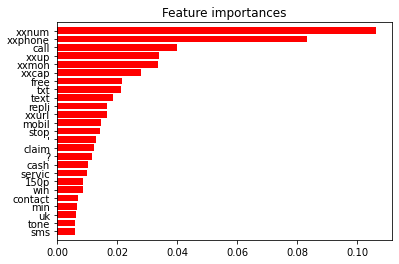

In [21]:
def plot_feature_importances(model, vectorizer, max_num=10):
    str_to_int = vectorizer.vocabulary_
    int_to_str = {val:key for key,val in str_to_int.items()}
    top_importances = -np.sort(-model.feature_importances_)[:max_num]
    top_importances = np.sort(top_importances)
    top_features = np.argsort(-model.feature_importances_)[:max_num]
    #top_features = np.sort(top_features)
    top_words = [int_to_str[i] for i in top_features]
    top_words = reversed(top_words)
    
    plt.figure()
    plt.title('Feature importances')
    plt.barh(range(max_num), top_importances,
             color='r', align='center')
    plt.yticks(range(max_num), top_words)
    plt.ylim([-1, max_num])
    plt.show()

plot_feature_importances(model, tfidf, 25)